In [1]:
from sys import call_tracing
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS, SpectralEmbedding, TSNE, Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import OPTICS, DBSCAN, KMeans
from sklearn.metrics import pairwise_distances
import umap
import mpl_toolkits.mplot3d.axes3d as p3
import os

In [2]:
win_size = 10
use_log = True
use_std = True
# ignore the first day
ignored = 1440

# group_func = 'mean'
group_func = 'mean_and_median'

# umap n_neighbors argument
nn = 50

reducers = {
    'pca': PCA(n_components=3),
    # 'umap': umap.UMAP(n_components=3, metric='cosine', n_neighbors=5, random_state=5566),
    'umap': umap.UMAP(n_components=3, metric='cosine', n_neighbors=nn, random_state=5566),
    # 'umap': umap.UMAP(n_components=3, n_neighbors=15, random_state=5566),
}
# reducer_name = 'pca'
reducer_name = 'umap'
reducer = reducers[reducer_name]
# custom_profile = 'nocustom'
custom_profile = 'cosine-nn%d' % nn
profile = '_'.join([reducer_name, 'log' if use_log else 'nolog', group_func, 'std' if use_std else 'nostd', 'ignore%d' % ignored, custom_profile])
print(profile)

umap_log_mean_and_median_std_ignore1440_cosine-nn50


In [3]:
conv_size = 3
txts = [f for f in os.listdir('./aligned') if f.endswith('.txt')]
monitor_cleaned_smooths = []
act_digests = []
act_origs = []
metas = []

#one_meta2 = pd.read_csv('./meta/one_meta2.csv', sep='\t')
one_meta2_test = pd.read_csv('./meta/one_meta2_test.csv', sep='\t')
for txt in txts:

    # try:
    #     meta = pd.read_csv('./meta/%s' % txt, sep='\t')
    # except:
    #     continue

    meta = one_meta2_test[one_meta2_test.File_Name == os.path.splitext(txt)[0]]
    #meta = one_meta2[one_meta2.File_Name == os.path.splitext(txt)[0]]
    if len(meta) == 0:
        print(txt)
        continue

    monitor = pd.read_csv('./aligned/%s' % txt, sep='\t', header=None)
    monitor = monitor.rename({1:'date', 2:'time'}, axis=1)
    monitor_cleaned = pd.concat([monitor.iloc[:,1:3], monitor.iloc[:,10:]], axis=1)
    monitor_cleaned = monitor_cleaned.iloc[ignored:,:]
    
    #### light dark filter implementation
    #hms = np.array([t.replace(' ', ':').split(':') for t in monitor_cleaned.time], dtype=int)
    #monitor_cleaned['h'] = hms[:,0]
    
    # light
    #monitor_cleaned = monitor_cleaned[(monitor_cleaned.h >= 5) & (monitor_cleaned.h <= 19)].iloc[:,:-1]
    
    # dark 
    #monitor_cleaned = monitor_cleaned[(monitor_cleaned.h <= 5) | (monitor_cleaned.h >= 19)].iloc[:,:-1]
    ####
    
    # monitor_cleaned_smooth = monitor_cleaned.iloc[:,2:].apply(np.convolve, v=np.array([1,1,1,1,1]), mode='valid')
    monitor_cleaned_smooth = monitor_cleaned.iloc[:,2:].apply(np.convolve, v=np.ones(conv_size), mode='valid')
    
    if use_log:
        monitor_cleaned_smooth = np.log(monitor_cleaned_smooth + 1)

    monitor_cleaned_smooth = pd.concat([monitor_cleaned.iloc[(conv_size-1):,:2].reset_index(drop=True), monitor_cleaned_smooth], axis=1)

    hms = np.array([t.replace(' ', ':').split(':') for t in monitor_cleaned_smooth.time], dtype=int)
    monitor_cleaned_smooth['h'] = hms[:,0]
    monitor_cleaned_smooth['mNcell'] = hms[:,1] // win_size
    #monitor_cleaned_smooth = monitor_cleaned_smooth[monitor_cleaned_smooth.h.isin([18,19,20,21,22,23,0,1,2,3,4,5])]
    #monitor_cleaned_smooth['m'] = hms[:,1]
    
    if group_func == 'mean':
        act_digest = pd.concat([monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T, monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T], axis=1)
    else:
        # act_digest = pd.concat([monitor_cleaned_smooth.groupby(['h', 'mNcell']).median().T, monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T], axis=1)
        q1 = monitor_cleaned_smooth.groupby(['h', 'mNcell']).apply(pd.DataFrame.quantile, q=.25).T.iloc[:-2]
        q3 = monitor_cleaned_smooth.groupby(['h', 'mNcell']).apply(pd.DataFrame.quantile, q=.75).T.iloc[:-2]

        monitor_cleaned_smooth_min = monitor_cleaned_smooth.groupby(['h', 'mNcell']).min().T.iloc[2:]
        monitor_cleaned_smooth_max = monitor_cleaned_smooth.groupby(['h', 'mNcell']).max().T.iloc[2:]
        IQR = q3 - q1
        monitor_cleaned_smooth_whisker_min = q1 - 1.5 * IQR
        monitor_cleaned_smooth_whisker_max = q3 + 1.5 * IQR
        
        whisker_min_oob = (monitor_cleaned_smooth_whisker_min < monitor_cleaned_smooth_min)
        whisker_max_oob = (monitor_cleaned_smooth_whisker_max > monitor_cleaned_smooth_max)
        monitor_cleaned_smooth_whisker_min[whisker_min_oob] = monitor_cleaned_smooth_min[whisker_min_oob]
        monitor_cleaned_smooth_whisker_max[whisker_max_oob] = monitor_cleaned_smooth_max[whisker_max_oob]
        
        act_digest = pd.concat([
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T, 
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T,
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).median().T, 
            q1,
            q3,
            monitor_cleaned_smooth_whisker_min,
            monitor_cleaned_smooth_whisker_max,
            ], axis=1)
    
    act_orig = monitor_cleaned_smooth.iloc[:,2:34].T
    #act_digest = monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T / monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T
    #act_digest = monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T
    act_digests.append(act_digest)
    act_origs.append(act_orig)

    metas.append(meta)
    monitor_cleaned_smooths.append(monitor_cleaned_smooth)

meta_union = pd.concat(metas).reset_index(drop=True)
np.sum(meta_union.Instar.isna())
act_digests_npy = np.concatenate(act_digests)
act_origs_npy = np.concatenate(act_origs)
monitor_cleaned_smooths_union = pd.concat(monitor_cleaned_smooths).reset_index(drop=True)


In [132]:
act_digests_npy.shape

(512, 462)

In [133]:
act_origs_npy.shape

(512, 1978)

In [4]:
### current cell: testing code

meta = one_meta2_test[one_meta2_test.File_Name == os.path.splitext(txt)[0]]
#meta = one_meta2[one_meta2.File_Name == os.path.splitext(txt)[0]]

monitor = pd.read_csv('./aligned/%s' % txt, sep='\t', header=None)
monitor = monitor.rename({1:'date', 2:'time'}, axis=1)
monitor_cleaned = pd.concat([monitor.iloc[:,1:3], monitor.iloc[:,10:]], axis=1)
monitor_cleaned = monitor_cleaned.iloc[ignored:,:]
monitor_cleaned

# only selecting nighttime activity data
hms = np.array([t.replace(' ', ':').split(':') for t in monitor_cleaned.time], dtype=int)
monitor_cleaned['h'] = hms[:,0]
monitor_cleaned = monitor_cleaned[(monitor_cleaned.h <= 5) | (monitor_cleaned.h >= 19)].iloc[:,:-1]
monitor_cleaned

,date,time,10,11,12,13,14,15,16,17,...,32,33,34,35,36,37,38,39,40,41
1440,17-Jan-21,19:00:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1441,17-Jan-21,19:01:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0
1442,17-Jan-21,19:02:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1443,17-Jan-21,19:03:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1444,17-Jan-21,19:04:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4975,20-Jan-21,5:55:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4976,20-Jan-21,5:56:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4977,20-Jan-21,5:57:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4978,20-Jan-21,5:58:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# 3D scatter plot
def scatter3d(data3d, color_map=None, azimuth=-74, elevation=54, figsize=(10, 10)):

    fig = plt.figure(figsize=figsize)
    ax = p3.Axes3D(fig)
    ax.view_init(elevation, azimuth)

    if color_map is None:
        ax.scatter(data3d[:,0], data3d[:,1], data3d[:,2],
                    s=30, edgecolor='k')
    else:
        ax.scatter(data3d[:,0], data3d[:,1], data3d[:,2],
                    color=plt.cm.jet(color_map),
                    s=30, edgecolor='k')
    return ax

def stdscaler (X, use_std=True):
    if use_std:
        return StandardScaler().fit_transform(X)
    else:
        return X

In [191]:
nn

50

In [75]:
reducer = umap.UMAP(n_components=3, metric='cosine', n_neighbors=50, random_state=5566)
#reducer = PCA(n_components=3, random_state=5566)

# try:
#     pwdists = pairwise_distances(dr)
# except:
act_digests_npy = np.concatenate(act_digests)
act_digests_npy_transformed = stdscaler(act_digests_npy, use_std)
dr = reducer.fit_transform(act_digests_npy_transformed)
act_digests_npy_transformed.shape
dr.shape
# reducer.fit(act_digests_npy_transformed)
# reducer.transform(act_digests_npy_transformed)
pwdists = pairwise_distances(dr)

pwdists.shape

(512, 512)

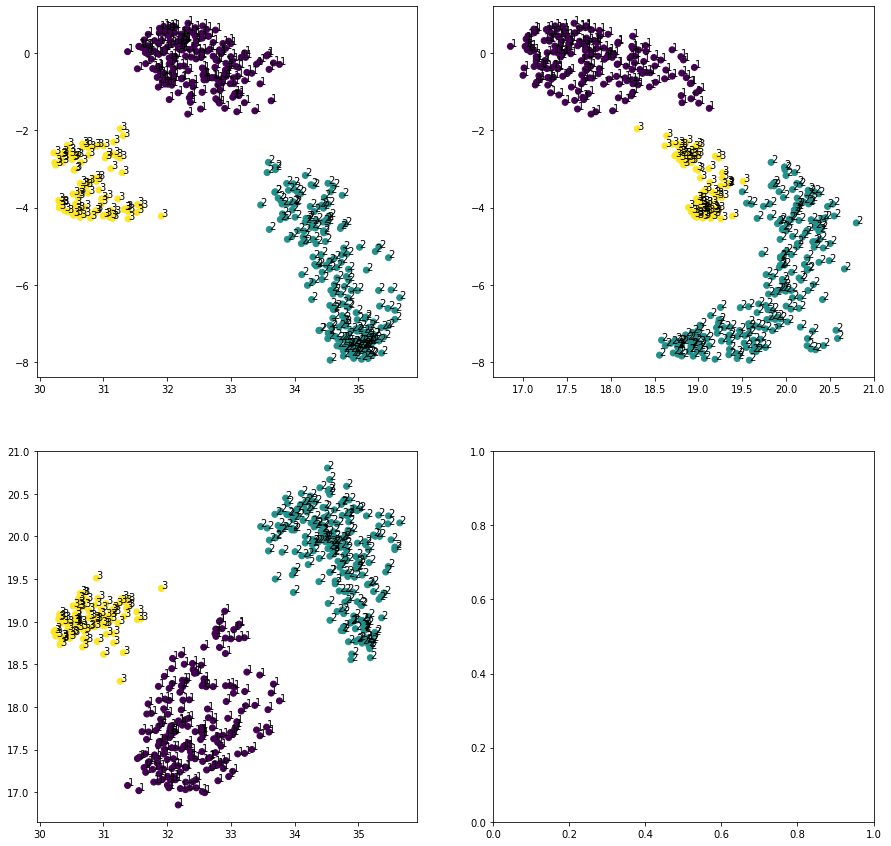

In [76]:
min_samples = 20

shortest_dists_mean = np.take_along_axis(pwdists, np.argsort(pwdists)[:,1:(1+min_samples)], axis=1).mean(axis=1)
shortest_dists_mean_std = shortest_dists_mean.std()
eps = shortest_dists_mean.mean() + 2 * shortest_dists_mean_std
clusterer = DBSCAN(eps=eps, min_samples=min_samples)
group_idxs_ = clusterer.fit_predict(dr) + 1
#kmeans = KMeans(n_clusters=15, init='k-means++', n_init=10, random_state=5566).fit(act_digests_npy)
#group_idxs_ = kmeans.predict(act_digests_npy) + 1
group_idxs = group_idxs_[group_idxs_ > 0]
dr_wg = dr[group_idxs_ > 0]
gcolor_map = group_idxs / (group_idxs.max() + 1)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0][0].scatter(dr_wg[:,0], dr_wg[:,1], c=gcolor_map)
axs[0][1].scatter(dr_wg[:,2], dr_wg[:,1], c=gcolor_map)
axs[1][0].scatter(dr_wg[:,0], dr_wg[:,2], c=gcolor_map)
for tid in range(dr_wg.shape[0]):
    axs[0][0].text(dr_wg[tid,0], dr_wg[tid,1], group_idxs[tid])
    axs[0][1].text(dr_wg[tid,2], dr_wg[tid,1], group_idxs[tid])
    axs[1][0].text(dr_wg[tid,0], dr_wg[tid,2], group_idxs[tid])
plt.show()

In [80]:
# adding a group column, organizing the scatterplot group 1,2,3 into data table
meta_union_with_group = meta_union.copy()
meta_union_with_group['group'] = group_idxs_
#meta_union_with_group.head(40)
a = meta_union_with_group[group_idxs_ == 3]#.iloc[:, : 50]#.head(50)
b = a.loc[meta_union['Source'] == 'WL']
c = b.loc[meta_union['Photo'] == 'L']
d = c.loc[meta_union['Instar'] == '1']
c


#meta_union.loc[meta_union['Photo'] == 'nan']

,ExpID,File_Name,Env,Setup,LD_cycle,Num,ID,Nest,Source,Location,...,End_Date,Soil,Bury,Eggs,Instar,Distance,Carcass,Phenotype,expression,group
27,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,28,S8962,n7488,WL,3_5,...,10/6/20,10.114,0.5,0.0,0.0,carcass,1.0,y,NaN,3
409,Loc0107-1,Monitor20210107_0111(1)_edit,long,soil,LD_4,26,T2464,n7952,WL,7585_7588,...,1/27/21,9.310,0.0,NaN,0.0,NaN,NaN,NaN,NaN,3
425,Loc0107-2,Monitor20210107_0111(2)_edit,long,soil,LD_4,10,T2210,n7949,WL,7578_7582,...,1/27/21,10.550,1.0,NaN,1.0,NaN,NaN,y,NaN,3
426,Loc0107-2,Monitor20210107_0111(2)_edit,long,soil,LD_4,11,T2557,n7975,WL,S9258_S9240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
448,Loc0116-1,Monitor20210116_0120(1)_edit,long,soil,LD_4,1,T2551,n7975,WL,S9258_S9240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
462,Loc0116-1,Monitor20210116_0120(1)_edit,long,soil,LD_4,15,T2547,n7975,WL,S9258_S9240,...,2/9/21,9.887,1.0,0.0,1.0,2.458,0.0,NaN,NaN,3
466,Loc0116-1,Monitor20210116_0120(1)_edit,long,soil,LD_4,19,T2548,n7975,WL,S9258_S9240,...,NaN,NaN,1.0,0.0,0.0,on carcass,1.0,y,NaN,3
486,Loc0116-2,Monitor20210116_0120(2)_edit,long,soil,LD_4,7,T2571,n7976,WL,S9507_S9277,...,2/9/21,9.760,1.0,0.0,1.0,NaN,0.0,NaN,NaN,3
509,Loc0116-2,Monitor20210116_0120(2)_edit,long,soil,LD_4,30,T2577,n7976,WL,S9507_S9277,...,2/2/21,9.754,0.0,0.0,0.0,0.746,0.0,s,NaN,3


In [178]:
meta_union_with_group.loc[meta_union_with_group['ID'] == 'T2559']

,ExpID,File_Name,Env,Setup,LD_cycle,Num,ID,Nest,Source,Location,...,End_Date,Soil,Bury,Eggs,Instar,Distance,Carcass,Phenotype,expression,group
494,Loc0116-2,Monitor20210116_0120(2)_edit,long,soil,LD_4,15,T2559,n7975,WL,S9258_S9240,...,2/9/21,9.76,1.0,0.0,1.0,on carcass,1.0,NaN,NaN,1


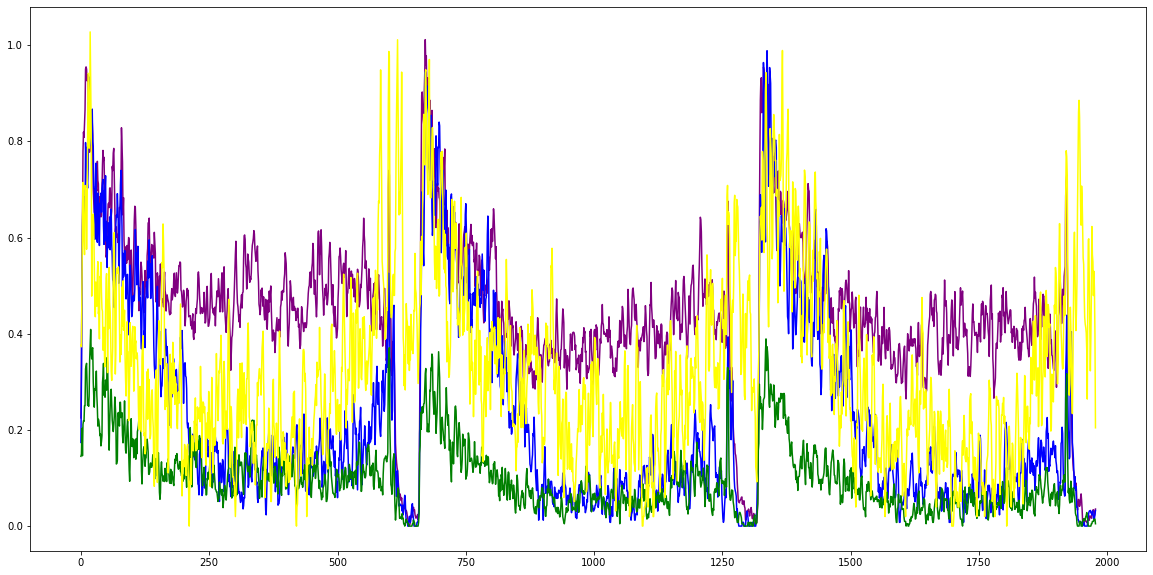

In [137]:
plt.figure(figsize=(20,10))
#plt.plot(act_origs_npy[group_idxs_ == 0].mean(axis=0)) #blue
plt.plot(act_origs_npy[group_idxs_ == 1].mean(axis=0), color='purple')
plt.plot(act_origs_npy[group_idxs_ == 2].mean(axis=0), color='blue')
plt.plot(act_origs_npy[group_idxs_ == 3].mean(axis=0), color='green')
plt.plot(act_origs_npy[group_idxs_ == 4].mean(axis=0), color='yellow')

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(act_digests_npy[group_idxs_ == 0].mean(axis=0)) #blue
plt.plot(act_digests_npy[group_idxs_ == 1].mean(axis=0)) #orange
plt.plot(act_digests_npy[group_idxs_ == 2].mean(axis=0)) #green
plt.plot(act_digests_npy[group_idxs_ == 3].mean(axis=0)) #red
#plt.plot(act_origs_npy[group_idxs_ == 4].mean(axis=0)) #purple

In [ ]:
act_digests_npy[group_idxs_ == 2]

In [ ]:
#np.unique(meta_union.Sex.values, return_inverse=True)
#meta_union.Photo.values
meta_union.loc[meta_union['Photo'] == 'nan']

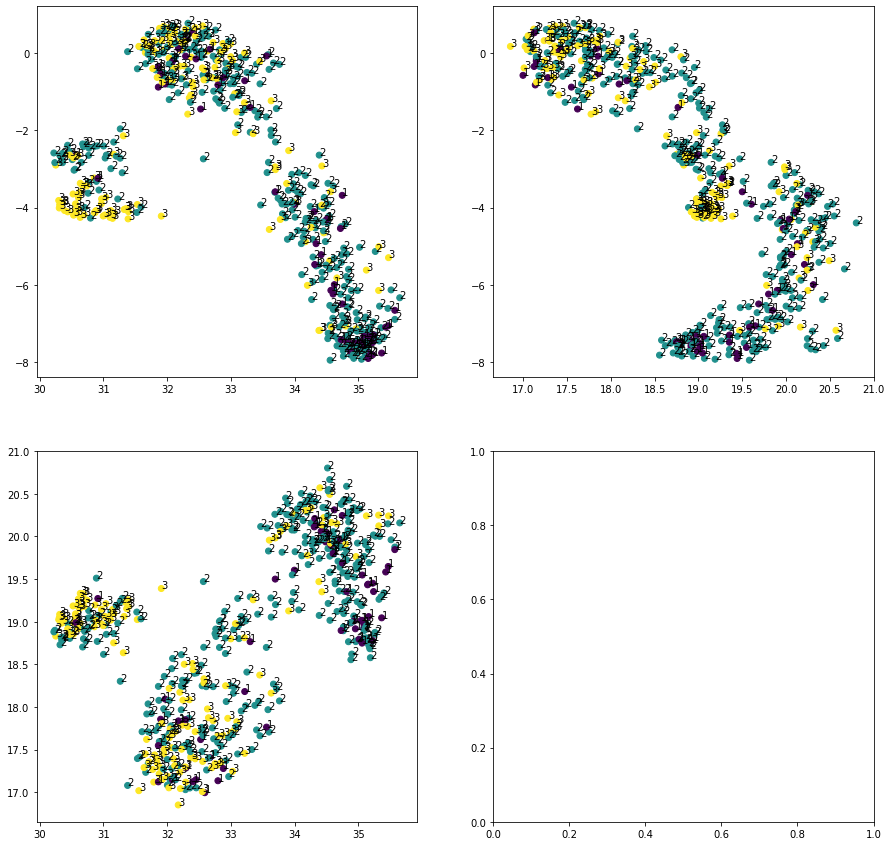

In [12]:
# less 1s in the smallest cluster?
#instar_values = meta_union.Source.values
#instar_values[meta_union.Source.isna()] = -1
instar_values = meta_union.Photo.values
instar_values[meta_union.Photo.isna()] = -1
#instar_values = instar_values.astype(int)
instar_values = np.unique(instar_values, return_inverse=True)[1]

gcolor_map_ = (instar_values+1) / (instar_values.max() + 1)
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0][0].scatter(dr[:,0], dr[:,1], c=gcolor_map_)
axs[0][1].scatter(dr[:,2], dr[:,1], c=gcolor_map_)
axs[1][0].scatter(dr[:,0], dr[:,2], c=gcolor_map_)
for tid in range(dr.shape[0]):
    axs[0][0].text(dr[tid,0], dr[tid,1], instar_values[tid]+1)
    axs[0][1].text(dr[tid,2], dr[tid,1], instar_values[tid]+1)
    axs[1][0].text(dr[tid,0], dr[tid,2], instar_values[tid]+1)
plt.show()

In [126]:
# y_ = meta_union.Instar.values
# y_[meta_union.Instar.isna()] = -1
# y = y_[y_ != -1]
# len(y)
# y.sum()

# #x_ = meta_union[['Source', 'Gen', 'Sex']].copy()
# x_ = meta_union[['Sex']].copy()
# x_['group'] = group_idxs_
# x = x_[y_ != -1].copy()

# meta_union[x_.group==3]
# meta_union.columns

Index(['ExpID', 'File_Name', 'Env', 'Setup', 'LD_cycle', 'Num', 'ID', 'Nest',
       'Source', 'Location', 'Elevation', 'Gen', 'Sex', 'Photo', 'Circ',
       'Subj_activity', 'Act_index', 'Breeding_nest', 'Start_Date', 'End_Date',
       'Soil', 'Bury', 'Eggs', 'Instar', 'Distance', 'Carcass', 'Phenotype',
       'expression'],
      dtype='object')

In [144]:
# using activity patterns to predict source
# meta_union.(Instar, Source, Bury, Gen, Photo).values 
s, y_ = np.unique(meta_union.Instar.values, return_inverse=True)
y_[meta_union.Instar.isna()] = -1
y = y_[y_ != -1]
len(y)
y.sum()

#x_ = meta_union[['Source', 'Gen', 'Sex']].copy()
#x_ = meta_union[['']].copy()
#x_['group'] = group_idxs_

x_ = pd.DataFrame(group_idxs_, columns=['group'])

x = x_[y_ != -1].copy()

#meta_union[x_.group==3]
meta_union.columns

Index(['ExpID', 'File_Name', 'Env', 'Setup', 'LD_cycle', 'Num', 'ID', 'Nest',
       'Source', 'Location', 'Elevation', 'Gen', 'Sex', 'Photo', 'Circ',
       'Subj_activity', 'Act_index', 'Breeding_nest', 'Start_Date', 'End_Date',
       'Soil', 'Bury', 'Eggs', 'Instar', 'Distance', 'Carcass', 'Phenotype',
       'expression'],
      dtype='object')

In [150]:
# adding a group column, organizing the scatterplot groups into data table
meta_union_with_group = meta_union.copy()
meta_union_with_group['group'] = group_idxs_
meta_union_with_group.head(40)
meta_union_group[group_idxs_ == 2]

NameError: name 'meta_union_group' is not defined

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [145]:
# in order for feature_importances_ to work, should only run rfc = RandomForestClassifier()
rfc = RandomForestClassifier(random_state=5566, max_depth=6, n_estimators=200, criterion='entropy')
#rfc = DecisionTreeClassifier(criterion='entropy', max_depth=3)
#rfc = SVC(kernel='linear')
#rfc = LogisticRegression()

In [38]:
meta_union.Gen.values

array(['WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'F20', 'WT', 'WT',
       'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT',
       'WT', 'WT', 'WT', 'F20', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT',
       'WT', 'F20', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT',
       'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT',
       'WT', 'WT', 'WT', 'WT', 'WT', 'F20', 'WT', 'WT', 'WT', 'WT', 'WT',
       'WC', 'WT', 'WC', 'WC', 'WC', 'WT', 'WC', 'WC', 'WC', 'WC', 'WC',
       'WC', 'WC', 'WC', 'WC', 'WC', 'WC', 'WT', 'WC', 'WC', 'WC', 'WC',
       'WC', 'WC', 'WC', 'WC', 'WC', 'WC', 'WC', 'WC', 'WT', 'WT', 'WT',
       'WT', 'WT', 'WT', 'F20', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT',
       'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'F20',
       'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT',
       'WT', 'WT', 'WT', 'WT', 'F20', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT',
       'WT', 'WT', 'WT', 'WT', 'WT', 'WT', '

In [146]:
# define x_train, y_train, etc.
enc = OneHotEncoder(sparse=False).fit(x)
new_x = enc.transform(x)
new_x.shape
x_train, x_test, y_train, y_test = train_test_split(new_x, y, test_size=.5, random_state=42)
enc.categories_

[array([0, 1, 2, 3])]

In [44]:
### run GridSearchCV
# url: https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv
rfc=RandomForestClassifier(random_state=5566)
param_grid = { 
    'n_estimators': [200, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 200}

In [45]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 2000, max_depth=6, criterion='entropy')
rfc1.fit(x_train, y_train)
pred=rfc1.predict(x_test)
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.6640625


In [51]:
enc = OneHotEncoder(sparse=False).fit(x)
new_x = enc.transform(x)
new_x.shape
x_train, x_test, y_train, y_test = train_test_split(new_x, y, test_size=.5, random_state=42)
# rfc.fit(x_train, y_train)
# rfc.score(x_test, y_test)
# rfc.score(x_train, y_train)
# rfc.feature_importances_
enc.categories_

[array(['BF', 'MF', 'OK', 'SC', 'WL'], dtype=object), array([0, 1, 2, 3])]

In [147]:
rfc.fit(x_train, y_train)
accuracy_score(y_train, rfc.predict(x_train))
rfc.score(x_test, y_test)
accuracy_score(y_test, rfc.predict(x_test))

0.6343283582089553

In [148]:
rfc.feature_importances_
#np.argsort(np.abs(rfc.coef_))
np.argsort(rfc.feature_importances_)

array([3, 0, 1, 2])

In [149]:
#np.concatenate(enc.categories_, axis=0)[np.argsort(np.abs(rfc.coef_))][:,-5:]
np.concatenate(enc.categories_, axis=0)[np.argsort(rfc.feature_importances_)][-5:]

array([3, 0, 1, 2])

In [104]:
meta_union[meta_union.Source=='OK']

x_test[:,2].astype(int)
y_test

np.sum(x_test[:,3] == y_test) / len(y_test)
np.sum(x_test[:,3] != y_test) / len(y_test)

np.sum(new_x[:,3] == y) / len(y)

meta_union.Instar

enc.categories_

[array(['F', 'M'], dtype=object), array([0, 1, 2, 3])]

In [8]:
act_origs_npy

array([[0.69314718, 0.69314718, 0.69314718, ..., 0.        , 0.        ,
        0.        ],
       [0.69314718, 0.69314718, 0.69314718, ..., 0.69314718, 0.69314718,
        0.        ],
       [0.69314718, 0.69314718, 0.69314718, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.79175947, 1.79175947, 0.69314718, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [14]:
filter_source = (meta_union['Source'] == 'MF') | (meta_union['Source'] == 'WL')

In [16]:
# only select rows where Source = X
# df.loc[df['column_name'] == some_value]
meta_union[filter_source]

,ExpID,File_Name,Env,Setup,LD_cycle,Num,ID,Nest,Source,Location,...,Start_Date,End_Date,Soil,Bury,Eggs,Instar,Distance,Carcass,Phenotype,expression
1,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,2,S9498,n7588,WL,1_2,...,9/30/20,10/6/20,10.002,0.0,0.0,0.0,0.637,0.0,s,NaN
3,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,4,S9286,n7578,WL,3_3,...,9/30/20,10/6/20,10.137,0.0,0.0,0.0,1.358,0.0,s,NaN
5,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,6,S8960,n7488,WL,3_5,...,9/30/20,10/6/20,10.002,0.0,0.0,0.0,1.053,0.0,s,NaN
6,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,7,S9211,n7565,WL,1_1,...,9/30/20,10/6/20,10.091,0.0,0.0,0.0,0.802,0.0,s,NaN
7,Loc0924,Monitor20200924_0928_soil,warmroom,soil,LD_4,8,S9461,n7583,WL,1_1,...,9/30/20,10/6/20,10.091,0.0,0.0,0.0,0.923,0.0,s,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,Loc0116-2,Monitor20210116_0120(2)_edit,long,soil,LD_4,24,T2572,n7976,WL,S9507_S9277,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
505,Loc0116-2,Monitor20210116_0120(2)_edit,long,soil,LD_4,26,T2539,n7975,WL,S9258_S9240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
507,Loc0116-2,Monitor20210116_0120(2)_edit,long,soil,LD_4,28,T2460,n7952,WL,7585_7588,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509,Loc0116-2,Monitor20210116_0120(2)_edit,long,soil,LD_4,30,T2577,n7976,WL,S9507_S9277,...,1/26/21,2/2/21,9.754,0.0,0.0,0.0,0.746,0.0,s,NaN


In [20]:
act_filter = act_origs_npy[filter_source]

array([[0.69314718, 0.69314718, 0.69314718, ..., 0.69314718, 0.69314718,
        0.        ],
       [1.09861229, 1.09861229, 0.69314718, ..., 0.        , 0.        ,
        0.        ],
       [0.69314718, 0.69314718, 0.69314718, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.79175947, 1.79175947, 0.69314718, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

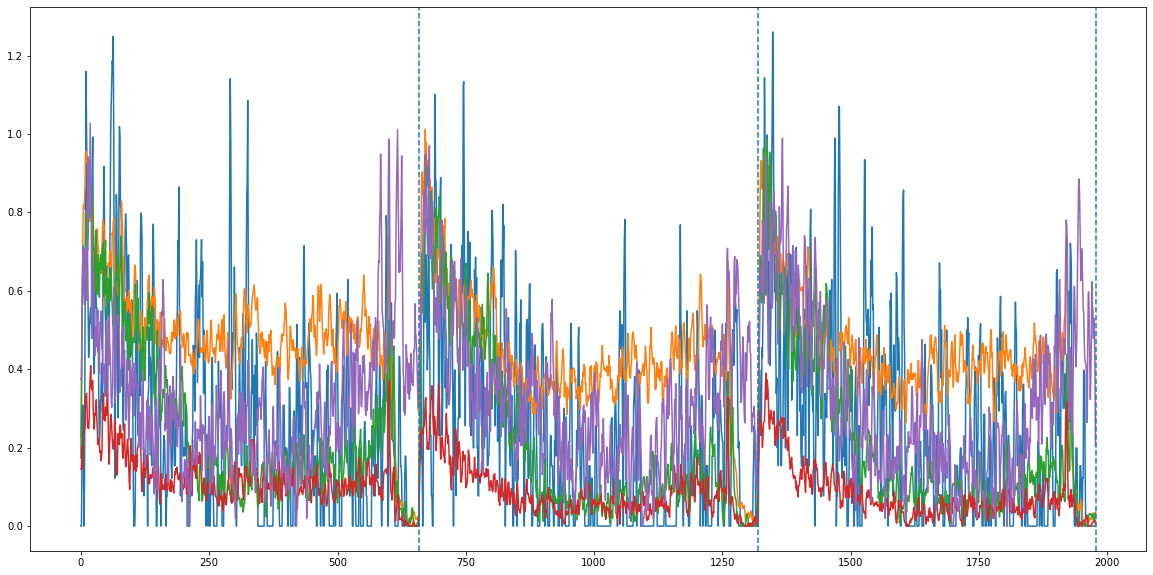

In [64]:
plt.figure(figsize=(20,10))
plt.plot(act_origs_npy[group_idxs_ == 0].mean(axis=0)) #blue
plt.plot(act_origs_npy[group_idxs_ == 1].mean(axis=0)) #orange
plt.plot(act_origs_npy[group_idxs_ == 2].mean(axis=0)) #green
plt.plot(act_origs_npy[group_idxs_ == 3].mean(axis=0)) #red
plt.plot(act_origs_npy[group_idxs_ == 4].mean(axis=0)) #purple
# light = 899.33
# dark = 659.33
plt.axvline(659.33, linestyle='--')
plt.axvline(659.33*2, linestyle='--')
plt.axvline(659.33*3, linestyle='--')

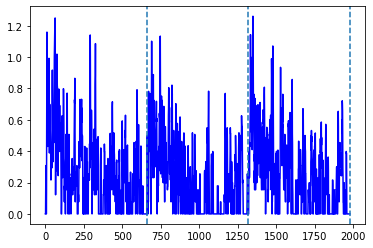

In [60]:
plt.plot(act_origs_npy[group_idxs_ == 0].mean(axis=0), color='blue')
# light = 899.33
# dark = 659.33
plt.axvline(659.33, linestyle='--')
plt.axvline(659.33*2, linestyle='--')
plt.axvline(659.33*3, linestyle='--')

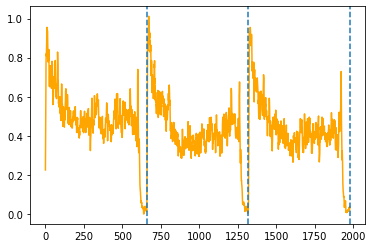

In [59]:
plt.plot(act_origs_npy[group_idxs_ == 1].mean(axis=0), color='orange')
# light = 899.33
# dark = 659.33
plt.axvline(659.33, linestyle='--')
plt.axvline(659.33*2, linestyle='--')
plt.axvline(659.33*3, linestyle='--')

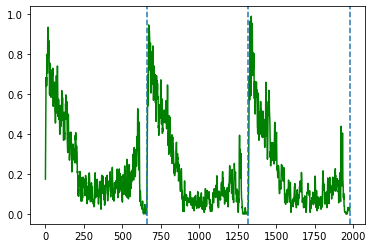

In [61]:
plt.plot(act_origs_npy[group_idxs_ == 2].mean(axis=0), color='green')
# light = 899.33
# dark = 659.33
plt.axvline(659.33, linestyle='--')
plt.axvline(659.33*2, linestyle='--')
plt.axvline(659.33*3, linestyle='--')

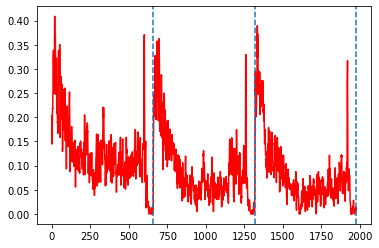

In [62]:
plt.plot(act_origs_npy[group_idxs_ == 3].mean(axis=0), color='red')
# light = 899.33
# dark = 659.33
plt.axvline(659.33, linestyle='--')
plt.axvline(659.33*2, linestyle='--')
plt.axvline(659.33*3, linestyle='--')

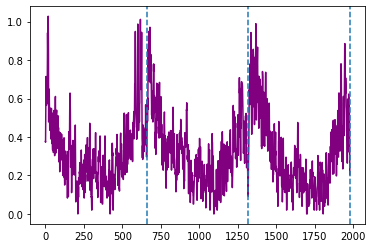

In [63]:
plt.plot(act_origs_npy[group_idxs_ == 4].mean(axis=0), color='purple')
# light = 899.33
# dark = 659.33
plt.axvline(659.33, linestyle='--')
plt.axvline(659.33*2, linestyle='--')
plt.axvline(659.33*3, linestyle='--')

In [ ]:
def packing(df, bug_col = 2):
    window_acts_per_bug.append(df.iloc[:,bug_col].values)
    return None

# for bug_col in range(2, 34):
bug_col=33
window_acts_per_bug = []
dum = monitor_cleaned_smooths_union.groupby(['h', 'mNcell']).apply(packing, bug_col=bug_col)
plt.boxplot(window_acts_per_bug)
plt.show()

In [166]:
# cand_cols = ['LD_cycle', 'Nest', 'Source', 'Location', 'Elevation', 'Gen', 'Sex', 'Photo']
# cand_cols = ['Nest', 'Source', 'Elevation', 'Gen', 'Sex', 'Photo']
cand_cols = ['Instar']
#cand_cols = ['']
# cand_cols = ['LD_cycle', 'Source', 'Photo']
# np.array(np.meshgrid(cand_cols, cand_cols)).T.reshape(-1, 2)
for i in range(len(cand_cols)):
    for j in range(i, len(cand_cols)):
        cat_col = list(np.unique([cand_cols[i], cand_cols[j]]))
        print(cat_col)

        meta_union = pd.concat(metas).reset_index(drop=True)
        act_digests_npy = np.concatenate(act_digests)

        # filtered_idx = meta_union.Source.isin(['BF', 'MF'])
        # # filtered_idx = meta_union.Source.isin(['WL'])
        # # filtered_idx = meta_union.Source.isin(['WL'])
        # meta_union = meta_union[filtered_idx]
        # act_digests_npy = act_digests_npy[filtered_idx]

        # cat_col = ['Source', 'Photo', 'LD_cycle']
        # cat_col = ['Source']
        # cat_col = ['Source', 'Photo']
        cat_col_str = '_x_'.join(cat_col)
        meta_union[cat_col_str] = meta_union[cat_col].replace(np.nan, 'NaN').astype(str).apply('_x_'.join, axis=1)

        # meta_union.groupby(cat_col).size()

        cat_list, cat_idxs = np.unique(meta_union[cat_col_str].values, return_inverse=True)
        color_map = cat_idxs / (cat_idxs.max() + 1)
        act_digests_npy_transformed = stdscaler(act_digests_npy, use_std)

        dr = reducer.fit_transform(act_digests_npy_transformed)
        # dr = dr[group_idxs_ > 0]
        # color_map = color_map[group_idxs_ > 0]
        # cat_idxs = cat_idxs[group_idxs_ > 0]

        # ax = scatter3d(dr, color_map)
        # for tid in range(dr.shape[0]):
        #     ax.text3D(dr[tid, 0], dr[tid, 1], dr[tid, 2], cat_idxs[tid])
        # plt.show()
        # plt.savefig('./explore/%s.png' % cat_col_str)
        # plt.close()

        if dr.shape[1] >= 3:
            print(cat_list)
            
            fig, axs = plt.subplots(2, 2, figsize=(15, 15))
            # print(axs)
            
            axs[0][0].scatter(dr[:,0], dr[:,1], c=color_map)
            axs[0][1].scatter(dr[:,2], dr[:,1], c=color_map)
            axs[1][0].scatter(dr[:,0], dr[:,2], c=color_map)
            for tid in range(dr.shape[0]):
                axs[0][0].text(dr[tid,0], dr[tid,1], cat_idxs[tid])
                axs[0][1].text(dr[tid,2], dr[tid,1], cat_idxs[tid])
                axs[1][0].text(dr[tid,0], dr[tid,2], cat_idxs[tid])
            try:
                os.makedirs('./explore/%s/' % profile,)
            except:
                pass

            plt.savefig('./explore/%s/%s.png' % (profile, cat_col_str))
            plt.close()
            plt.show()


['Instar']
['0.0' '1.0' 'NaN']


In [77]:
from scipy.stats import chisquare
#scipy.stats.chisquare(f_obs, f_exp=None, ddof=0, axis=0)

group_sizes = pd.DataFrame({'gid':group_idxs}).groupby('gid').size().values
# f_exp: array_like, optional 
# (Expected frequencies in each category. By default the categories are assumed to be equally likely.)
f_exp = group_sizes / group_sizes.sum()

# cand_cols = ['Nest', 'Source', 'Elevation', 'Gen', 'Sex', 'Photo', 'Instar']
cand_cols = ['Source']
#cand_cols = ['Sex']
#cand_cols = ['Gen']
# np.array(np.meshgrid(cand_cols, cand_cols)).T.reshape(-1, 2)
biased_chars_all = np.array([])
chi2_all = np.array([])
pvalue_all = np.array([])
char_sample_size_all = np.array([])
cat_col_str_all = np.array([])
for i in range(len(cand_cols)):
    for j in range(i, len(cand_cols)):
        cat_col = list(np.unique([cand_cols[i], cand_cols[j]]))

        meta_union = pd.concat(metas).reset_index(drop=True)
        act_digests_npy = np.concatenate(act_digests)

        cat_col_str = '_x_'.join(cat_col)

        print(cat_col_str)
        meta_union[cat_col_str] = meta_union[cat_col].replace(np.nan, 'NaN').astype(str).apply('_x_'.join, axis=1)

        char_to_group = pd.DataFrame.from_dict({'gid': group_idxs, 'char': meta_union[cat_col_str].values[group_idxs_ > 0]}).pivot_table(index='gid', columns='char', aggfunc=len)
        char_to_group = char_to_group.replace(np.nan, 0)

        f_exp_weighted = char_to_group.sum().values * np.repeat(np.expand_dims(f_exp, axis=0), char_to_group.shape[1], axis=0).T
        # pd.concat([char_to_group.reset_index(), pd.DataFrame(f_exp)], axis=1)
        chi2test = chisquare(char_to_group, f_exp=f_exp_weighted)
        
        # group_sizesT = meta_union[[cat_col_str]].groupby(cat_col_str).size().values
        # f_expT = group_sizesT / group_sizesT.sum()
        # chi2testT = chisquare(char_to_group.T, f_exp=np.repeat(np.expand_dims(f_expT, axis=0), char_to_group.shape[0], axis=0).T)
        # if (chi2testT.pvalue < 1e-4).all():
        #     print(cat_col_str)
        
        pvalue_thres_idxs = (chi2test.pvalue < 0.05)
        biased_chars = char_to_group.columns.values[pvalue_thres_idxs]
        biased_chars_all = np.append(biased_chars_all, biased_chars)
        chi2 = chi2test.statistic[pvalue_thres_idxs]
        chi2_all = np.append(chi2_all, chi2)
        pvalue_all = np.append(pvalue_all, chi2test.pvalue[pvalue_thres_idxs])
        char_sample_size_all = np.append(char_sample_size_all, char_to_group.sum()[pvalue_thres_idxs].values)
        cat_col_str_all = np.append(cat_col_str_all, np.repeat(cat_col_str, chi2.shape[0]))
        print(biased_chars)
        # print([d for d in char_to_group.columns.values if d not in biased_chars])

Source
['BF' 'OK' 'WL']


In [78]:
print(char_to_group)
print(chi2test)
print(pvalue_thres_idxs)
print(biased_chars_all)
print(chi2_all)
print(pvalue_all)
print(char_sample_size_all)
print(cat_col_str_all)

char  BF  MF  OK  SC  WL
gid                     
1     91   9  35  15  40
2     65  12  42  22  73
3     52   1   3   4  28
Power_divergenceResult(statistic=array([14.47500559,  2.83653173, 10.97468559,  2.53253141,  6.36276772]), pvalue=array([0.00071911, 0.24213355, 0.00413883, 0.28188229, 0.04152815]))
[ True False  True False  True]
['BF' 'OK' 'WL']
[14.47500559 10.97468559  6.36276772]
[0.00071911 0.00413883 0.04152815]
[208.  80. 141.]
['Source' 'Source' 'Source']


In [ ]:
biased_chars_all
biased_chars_all[np.argsort(chi2_all)[-5:]]
pvalue_all[np.argsort(chi2_all)[-5:]]
char_sample_size_all

pd.DataFrame({
    'char_name': np.array(cat_col_str_all)[char_sample_size_all > 20],
    'char_val': biased_chars_all[char_sample_size_all > 20],
    'pvalue': pvalue_all[char_sample_size_all > 20],
    'size': char_sample_size_all[char_sample_size_all > 20],
})

cat_col = ['Photo', 'Source']
meta_union = pd.concat(metas).reset_index(drop=True)
act_digests_npy = np.concatenate(act_digests)

cat_col_str = '_x_'.join(cat_col)
print(cat_col_str)
meta_union[cat_col_str] = meta_union[cat_col].replace(np.nan, 'NaN').astype(str).apply('_x_'.join, axis=1)
#char_to_group = pd.DataFrame.from_dict({'gid': group_idxs, 'char': meta_union[cat_col_str].values}).pivot_table(index='gid', columns='char', aggfunc=len)
# code below: added a _ after group_idxs
char_to_group = pd.DataFrame.from_dict({'gid': group_idxs_, 'char': meta_union[cat_col_str].values}).pivot_table(index='gid', columns='char', aggfunc=len)
char_to_group = char_to_group.replace(np.nan, 0)
char_to_group
f_exp

monitor_cleaned_smooth
meta_union

### problem with code line 20
'gid' and 'char' different length; group_idxs.shape = (492,) vs. meta_union[cat_col_str].values.shape(512,)
<br>Is it because outliers were removed in group_idxs?
<br>works when changed to group_idxs_.shape = (512,)